Once we have created a linear regression model, we would like to check it and see how well we can expect the model to perform as well as how well it compares to other models we might use.  There are a number of aspects to model checking since it eventually is a judgement call, so we will review standard tools for evaluating models by looking at examples and gaining intuition for the meaning of the statistical concepts we need.

### What are the basic assumptions of the linear regression model?
Linear regression will always predict a result when applied to a data set, but it may not be valid to interpret data according to the assumptions of linear regression.  The assumptions of linear regression include:

* **Validity** of the data.  The data used for the analysis is assumed to contain no errors.
* **Linearity** of the predictor/result (the relationship of $X$ to $Y$).
* **Normal Distribution** of the data.  Linear regression assumes that the result $Y$ is a random variable with a normal distribution, $Y \sim \mathcal{N}(\beta_0 + \beta_1X,\,\sigma^{2})$.  
* **Constant Variance** of the resuduals.  Another way to state the expression for $Y$ is $Y = \beta_0 + \beta_1X + \epsilon$, where $\epsilon \sim \mathcal{N}(0, \sigma^2)$.  Then $\epsilon = Y- \beta_0 - \beta_1X$ is the **residual** and is normally distributed about $0$ with a constant variance.
* **Independence** of the residuals.  Each data point used to approximate the regression is taken independently of the other data points.

Often, especially with multiple regression, it becomes very difficult to judge the validity of these assumptions. 

### What are the basic concepts of model evaluation?
The primary task of model evaluation is to verify to what extent a regression model holds up to the assumptions outlined above.  Before we look at the concepts of model evaluation, we should realize that even if the regression assumptions are valid, we do not know the true regression formulation.  We can only know an approximate regression calculated from the data we know.

In order to have an example for the rest of this discussion, we will load some data on advertising and create a model (or two) on it.

In [421]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# This function generates a formatted data frame of the basic statistics of the model coefficients.
def get_VIF(X):
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    return vif

def show_model_stats(results):
  #df = pd.DataFrame([results.params, results.bse, results.tvalues, results.pvalues, results.conf_int()], \
  #                       index=['coef', 'std.error', 't value', 'p value', '[0.025', '0.095]'])
  df = pd.DataFrame([results.params, results.bse, results.tvalues, results.pvalues], \
                         index=['coef', 'std.error', 't value', 'p value'])
  df2 = results.conf_int()
  df2.columns = ([['[0.025', '0.975]']])
  return pd.concat([df, df2.transpose()], axis=0).round(3).transpose()

  #return resultsdf.transpose().round(3)
  
# generate a data frame containing row-level statistics
def get_row_level_statistics(results):
    influence = OLSInfluence(results).summary_frame()
    df = pd.DataFrame([results.fittedvalues, OLSInfluence(results).summary_frame()['standard_resid'], \
                    results.get_influence().hat_matrix_diag],
                    index=['Fitted_Values', 'Std_Residuals', 'Leverage'])
    return df.transpose()
    
def plot_standard_residuals(df, ax):
    a1 = df.plot(x='Fitted_Values', y='Std_Residuals', kind='scatter', ax=ax)
    #ax.plot(x=[df['Fitted_Values'].min(), df['Fitted_Values'].max()], y=[0,0], color='green')
    a1.hlines(y=0, xmin=df['Fitted_Values'].min(), xmax = df['Fitted_Values'].max(), color='r')
    return a1

def plot_residuals_vs_leverage(df, ax):
    a1 = df.plot(x='Leverage', y='Std_Residuals', kind='scatter', ax=ax)
    a1.hlines(y=0, xmin=df['Leverage'].min(), xmax = df['Leverage'].max(), color='r')
    return a1
    

In [422]:
df = pd.read_csv('Advertising.csv')
df.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [423]:
# check how is sales related to tv adds
y, X = dmatrices('sales ~ TV', data=df, return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
model1 = sm.OLS(y_train, sm.add_constant(X_train))
results1 = model1.fit()
show_model_stats(results1)

,coef,std.error,t value,p value,[0.025,0.975]
Intercept,6.800,0.492,13.832,0.0,5.829,7.771
TV,0.049,0.003,16.737,0.0,0.043,0.055


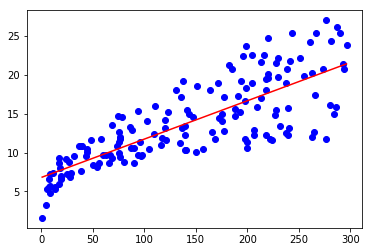

In [424]:
plt.scatter(X_train['TV'], y_train, color='b')
xlim = np.array([X_train['TV'].min(), X_train['TV'].max()])
plt.plot(xlim, results1.params[0] + results1.params[1]*xlim, color='r')
plt.show()

#### Residuals
We calculate residuals using the formula above for the error $\epsilon$ in the regression.

$$\epsilon = Y- \beta_0 - \beta_1X$$

This formula subtracts the $Y$ from the data to the predicted $Y$ from the regression line, leaving the error as the result.  The error $\epsilon$ is the residual and is used in a number of different ways to evaluate the model from which it is derived.


#### Heteroscedasticity (Non-constant Variance)
We use residuals to check for problems with the variance assumption by plotting the residuals to the fitted Y values. Non-constant variance is an assumption that is easy to spot in a graph of residuals (usually standardized) against  the x values of the input data.  There are basically three things to look for: 

* Normal residual assumption is met.
* Residuals depend on the x value in some increasing way.
* Residuals exhibit nonlinear patterns.

This example at [StackExchange](https://stats.stackexchange.com/questions/76226/interpreting-the-residuals-vs-fitted-values-plot-for-verifying-the-assumptions) below tries to illustrate these different conclusions.

#### Outliers
Another important use for residual values is to help identify outliers in our data.  One strong indicator of outliers is data points that have a high relative residual value.  This is easier to see when we use **Studentized Residuals**.  Studentized Residuals are the sample residuals from our regression scaled by the standard deviation of the sample residuals.  This makes the units of the residual axis into standard deviations.  This lets us tell how many standard deviations from the origin each residual error is.  Outliers will tend to have a large standard deviation but most of the data (around 95%) will be inside of +-2 standard deviations.

#### Leverage and Influence
Outliers may also have very low residuals if they happen to be close to the regression line.  With these types of outliers, we need to have alternative methods of investigation.  

**Leverage** is a concept we use to understand how much points far away from the average predictor ($x$) value can affect the direction of the regression line.  These types of points act to "lever" the regression line to a different angle when they are present.  Leverage is calculated by removing points and recalculation regression one at a time.  For each point the new regression coefficients are compared with the full regression to see how much leverage affect is provided by the point.   The slope of the regression line will change more radically for points with high leverage. 

**Influence** is the property of any point to influence the quality of the regression.  Points with high influence may have High leverage or they may have a high residual value, or both.  We can investigate influence using Cook's distance, discussed in more detail below.

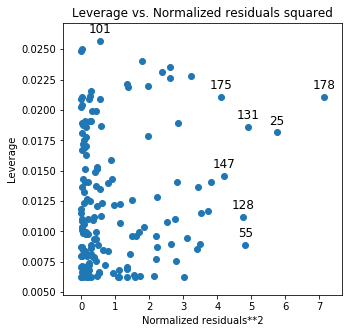

In [425]:
fig, ax = plt.subplots(figsize=(5,5))
fig = sm.graphics.plot_leverage_resid2(results1, alpha  = 0.05, ax = ax)

plt.show()

#### Colinearity and Variance Inflation 
With mulivariate linear regression, when more than one predictor variable is being used, it becomes important to determine if certain variables are **colinear**.  Colinearity means that two variables (i.e., columns of the training data) are very closely aligned for the purposes of calculating the regression line.  That means that one of the variables is not needed and that makes the model simpler.  We can look at the ```scatter_matrix``` plot to see if there is correlation between two values.  We can also look at the **Variance Inflation Factor** (VIF).  The VIF matches for parameters that are colinear, allowing us to easily identify them. 

#### Confidence Interval
The Confidence interval is the range of possible values of a coefficient that have a specific likelyhood of being in the range.  For a normal distribution, this is $\pm 2\sigma\beta_i$ for the ith coefficient estimate to be within that range at 95% confidence.


#### t-Statistic
The t-Statistic gives us a measure of confidence about the null hypothesis by tellin gus how many standard deviations away from zero is the $\beta_i$ coefficient.  If it is more than 3 standard deviations from zero, then we are confident that the y value we are estimating depends on this variable x.

Below is some sample output for different models created on the advertising data set.


In [426]:
# check how is sales related to radio ads
y, X = dmatrices('sales ~ radio', data=df, return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
model2 = sm.OLS(y_train, sm.add_constant(X_train))
show_model_stats(model2.fit())

,coef,std.error,t value,p value,[0.025,0.975]
Intercept,9.134,0.646,14.131,0.0,7.857,10.411
radio,0.201,0.023,8.638,0.0,0.155,0.247


In [427]:
# multivariate model with all variables
#df = pd.read_csv('Advertising.csv')
y, X = dmatrices('sales ~ radio + TV + newspaper', data=df, return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
model3 = sm.OLS(y_train, sm.add_constant(X_train))
results3 = model3.fit()

show_model_stats(results3)

,coef,std.error,t value,p value,[0.025,0.975]
Intercept,2.908,0.349,8.339,0.000,2.219,3.597
radio,0.179,0.010,17.751,0.000,0.159,0.198
TV,0.047,0.002,29.312,0.000,0.044,0.050
newspaper,0.003,0.007,0.356,0.723,-0.012,0.017


### What are the basic tools of model evaluation and comparison?


#### Residual Plot
Residual plots let us see the residual values against the x-values of our model.  We plaot residuals that are normalized using the residual standard deviation in order to use the plot to see the number of standard deviations away from the center each plot point is.  This plot:

* Helps identify if outliers are present
* Checks for breakdown of constant $\sigma$ assumption.


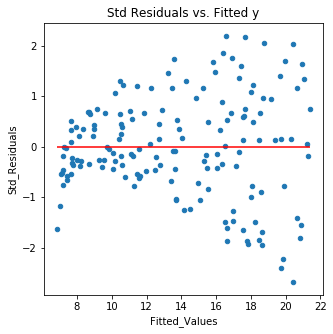

In [428]:
#residual plot of advertising data
pl,a1 = plt.subplots(nrows=1,ncols=1, figsize=(5,5), sharey=False,
                               subplot_kw = {'adjustable':'box-forced'})
a1 = plot_standard_residuals(get_row_level_statistics(results1), ax=a1)
a1.set_title('Std Residuals vs. Fitted y')
plt.show()

#### Leverage Plot
Plotting leverage against standardized residuals gives us an even better way to eyeball outliers.  Below are some made-up data sets with different properties.  


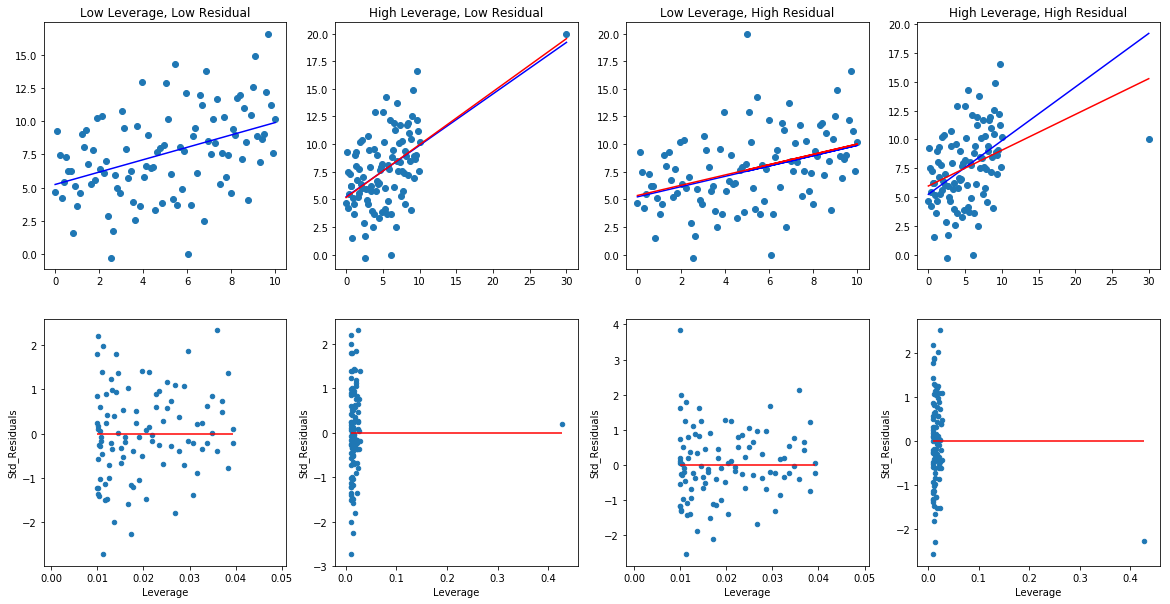

In [429]:
#Generate some data normal to a line
N = 100
x1 = np.linspace(0.0, 10.0, N)
y_model = lambda x: 5 + .5*x
y1 = np.array([np.random.normal(loc = y_model(_x), scale=3.0, size=1) for _x in x1])
lr1 = sm.OLS(y1, sm.add_constant(x1)).fit()

#add a "outlier" point 
x2 = np.append(x1, 30)
y2 = np.append(y1, 20)
lr2 = sm.OLS(y2, sm.add_constant(x2)).fit()

x3 = np.append(x1, 5)
y3 = np.append(y1, 20)
lr3 = sm.OLS(y3, sm.add_constant(x3)).fit()

x4 = np.append(x1, 30)
y4 = np.append(y1, 10)
lr4 = sm.OLS(y4, sm.add_constant(x4)).fit()

pl,((a1, a2, a3, a4), (b1, b2, b3, b4)) = plt.subplots(nrows=2,ncols=4, figsize=(20,10), sharey=False,
                               subplot_kw = {'adjustable':'box-forced'})

a1.scatter(x1, y1)
a1.plot(x1, lr1.params[0] + lr1.params[1]*x1, color='b')
a1.set_title('Low Leverage, Low Residual')
b1 = plot_residuals_vs_leverage(get_row_level_statistics(lr1), ax=b1)

a2.scatter(x2, y2)
a2.plot(x2, lr1.params[0] + lr1.params[1]*x2, color='b')
a2.plot(x2, lr2.params[0] + lr2.params[1]*x2, color='r')
a2.set_title('High Leverage, Low Residual')
b2 = plot_residuals_vs_leverage(get_row_level_statistics(lr2), ax=b2)

a3.scatter(x3, y3)
a3.plot(x3, lr1.params[0] + lr1.params[1]*x3, color='b')
a3.plot(x3, lr3.params[0] + lr3.params[1]*x3, color='r')
a3.set_title('Low Leverage, High Residual')
b3 = plot_residuals_vs_leverage(get_row_level_statistics(lr3), ax=b3)

a4.scatter(x4, y4)
a4.plot(x4, lr1.params[0] + lr1.params[1]*x4, color='b')
a4.plot(x4, lr4.params[0] + lr4.params[1]*x4, color='r')
a4.set_title('High Leverage, High Residual')
b4 = plot_residuals_vs_leverage(get_row_level_statistics(lr4), ax=b4)

plt.show()

#### Cook's Distance
Cook's Distance puts together both the Residual extreme points and the leveraged extreme points to get a complete view of outliers by combining the two measures.

In [430]:
# put Cook's Distance calcs here.
model_cooks = lr4.get_influence().cooks_distance[0]
#top 3 cooks distance
idx = np.argsort(model_cooks)[-3:][::-1]
cookstop3 = pd.DataFrame([y4[idx], x4[idx], model_cooks[idx]]).transpose()
cookstop3.columns = ['y', 'x', 'cooks_d']
cookstop3.index = idx
cookstop3
#print(model_cooks)

,y,x,cooks_d
100,10.000000,30.000000,1.930912
96,16.581013,9.696970,0.075892
90,14.930436,9.090909,0.041999


#### Quantile-Quantile (Q-Q) Plot
The QQ plot compares the theoretical cummulative values to the calculated cummulative distribution from the data.  We can use it to tell if the normal distribution assumption of the data is correct.

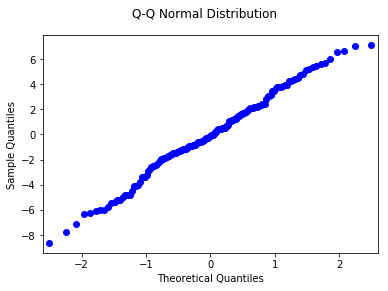

In [431]:
f = sm.qqplot(results1.resid) #.axes[0]
f.suptitle('Q-Q Normal Distribution')
plt.show()